['../output/1104/1104_6204_1200_B_F', '../output/1104/1104_6204_1200_OR_F']
['x.csv', 'z.csv', 'r.csv']


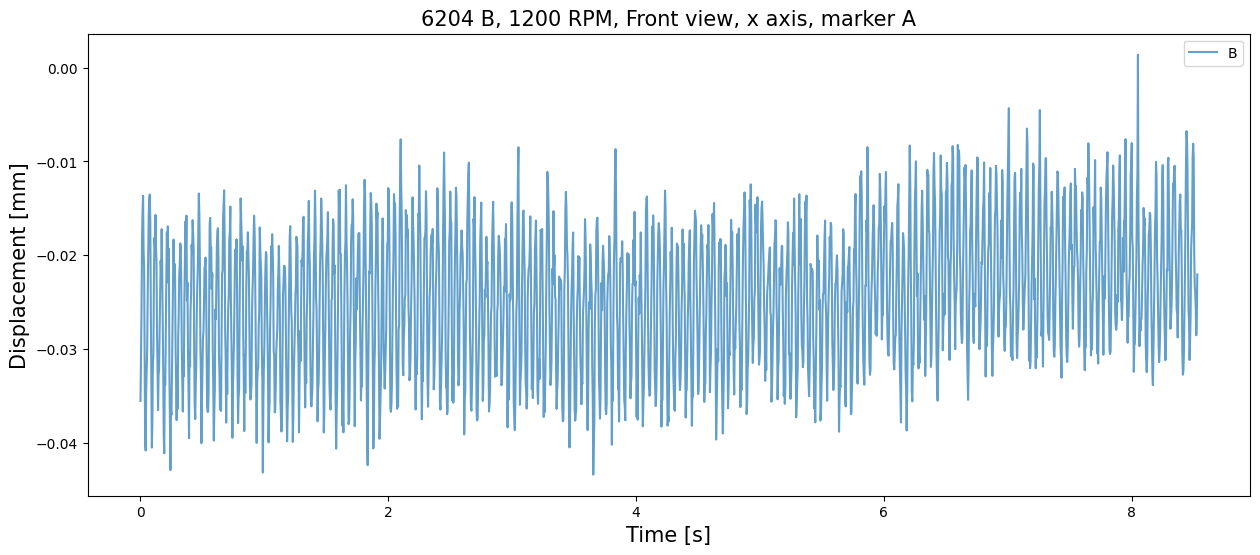

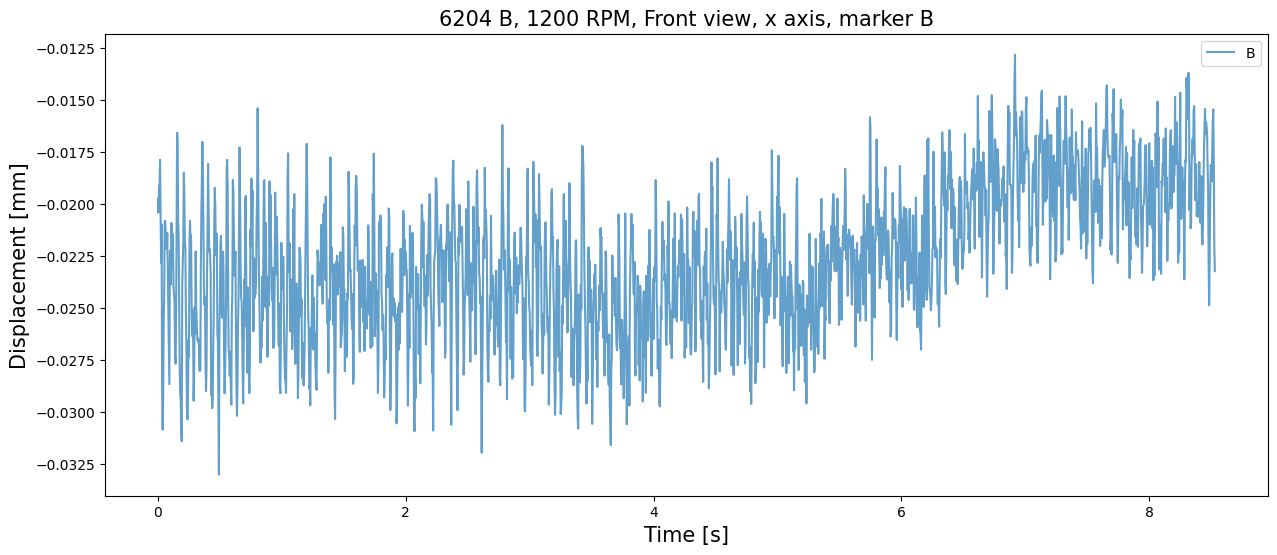

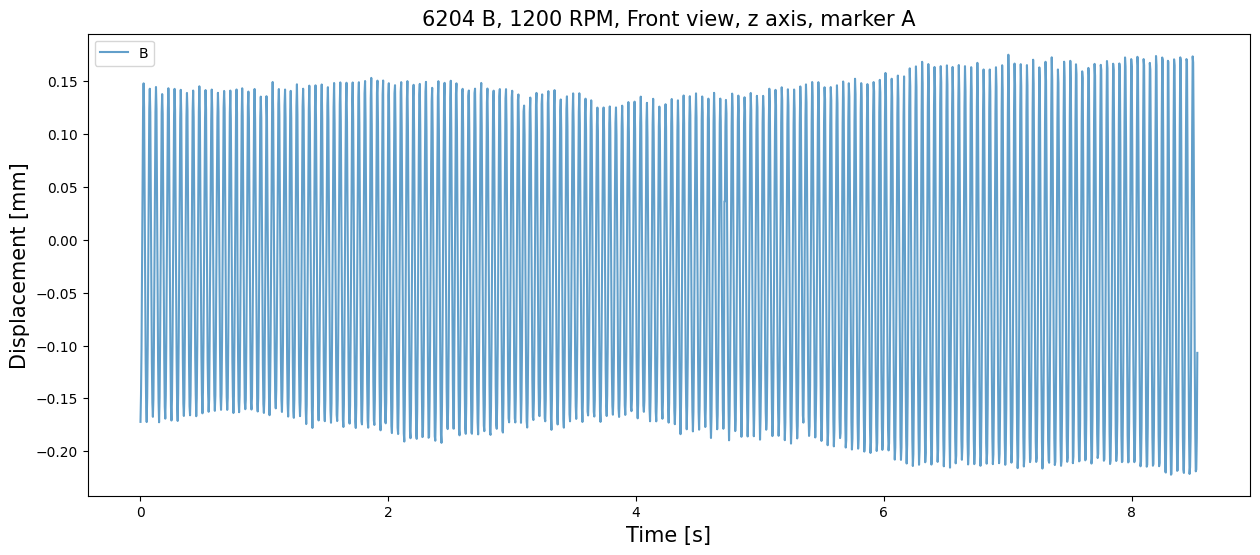

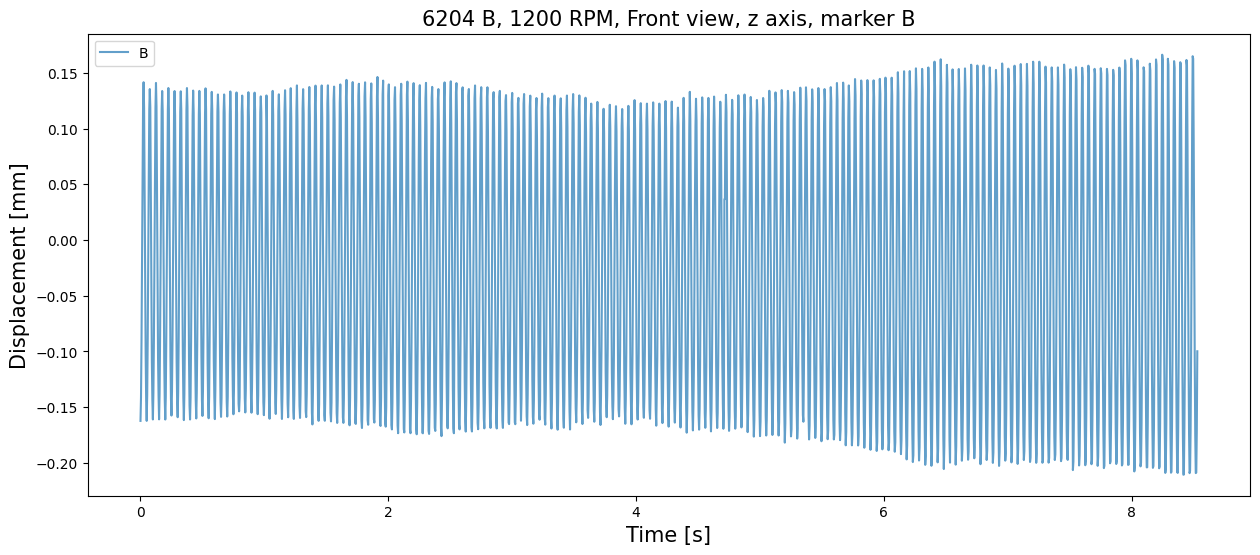

FileNotFoundError: [Errno 2] No such file or directory: '../output/1104/1104_6204_1200_B_F/r.csv'

In [2]:
from funs import *

#####################################
# 그래프 보고자 하는 타겟 디렉토리 설정     
target_dir = '../output/1104'
######################################

dir_list = get_dir_list(target_dir, target_view='F',target_rpm='1200')
print(dir_list)
draw_single_graphs(dir_list)

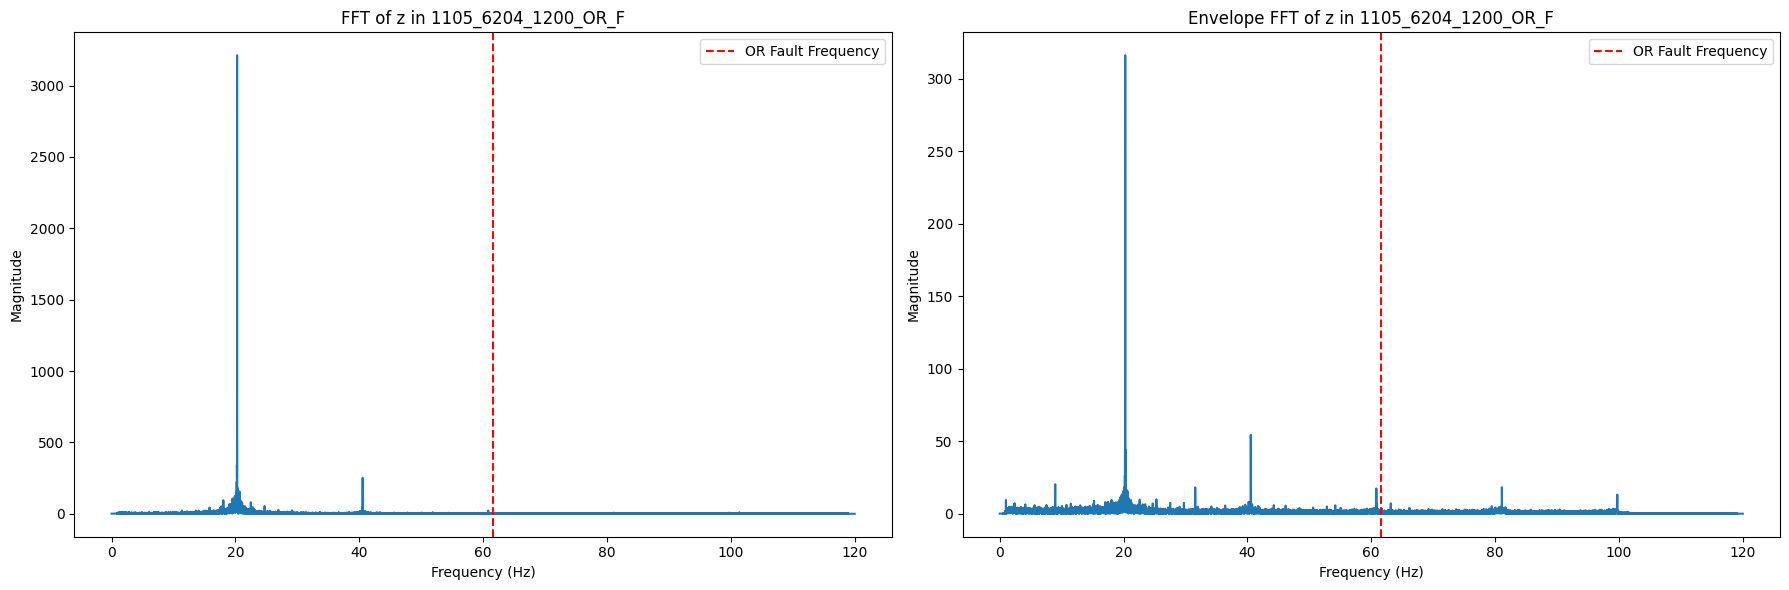

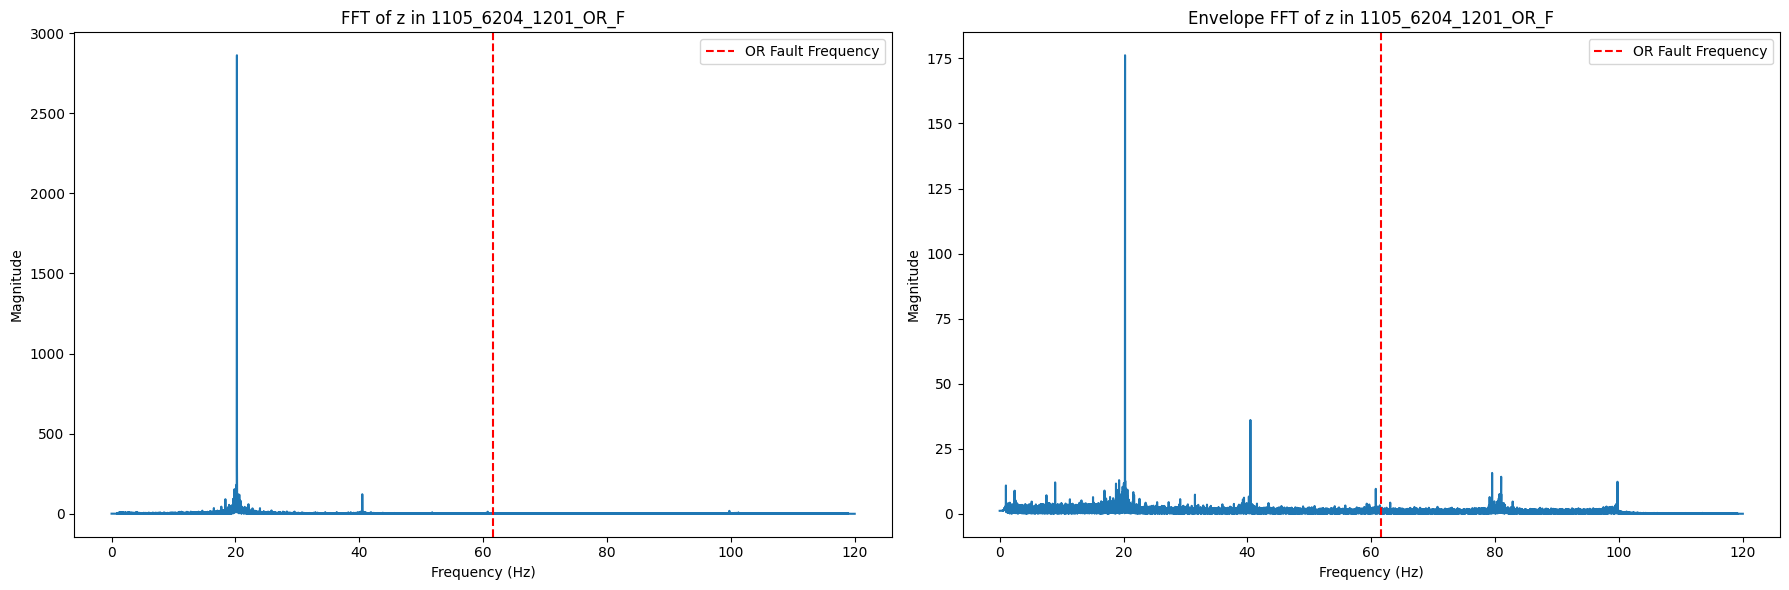

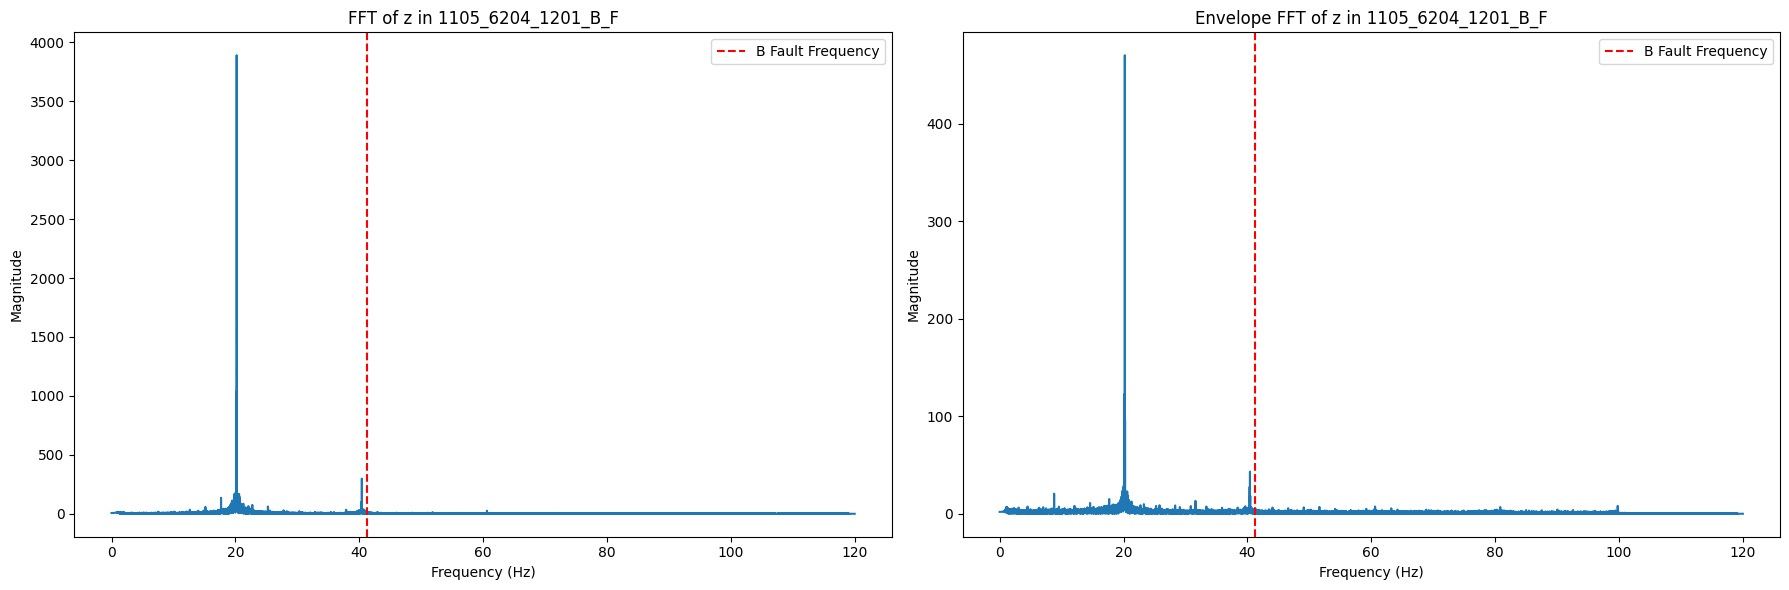

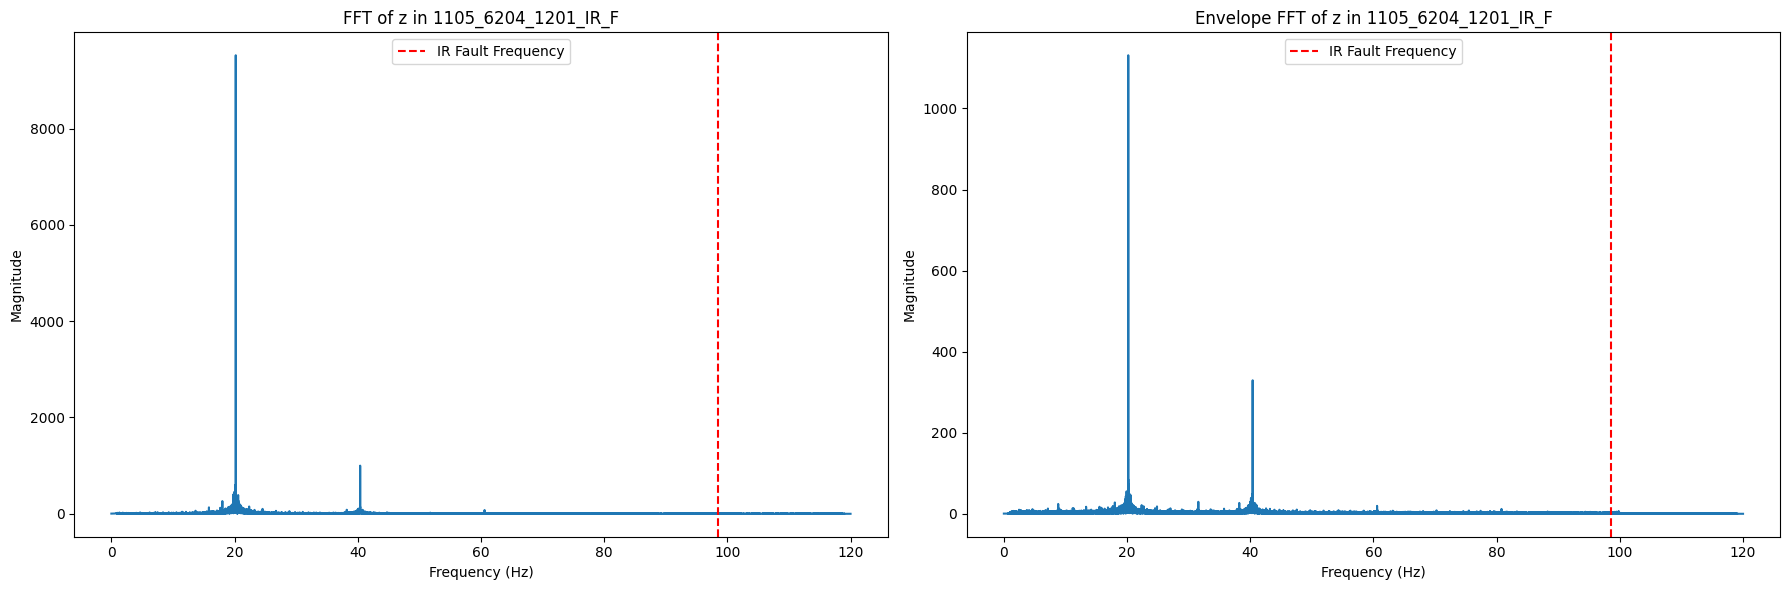

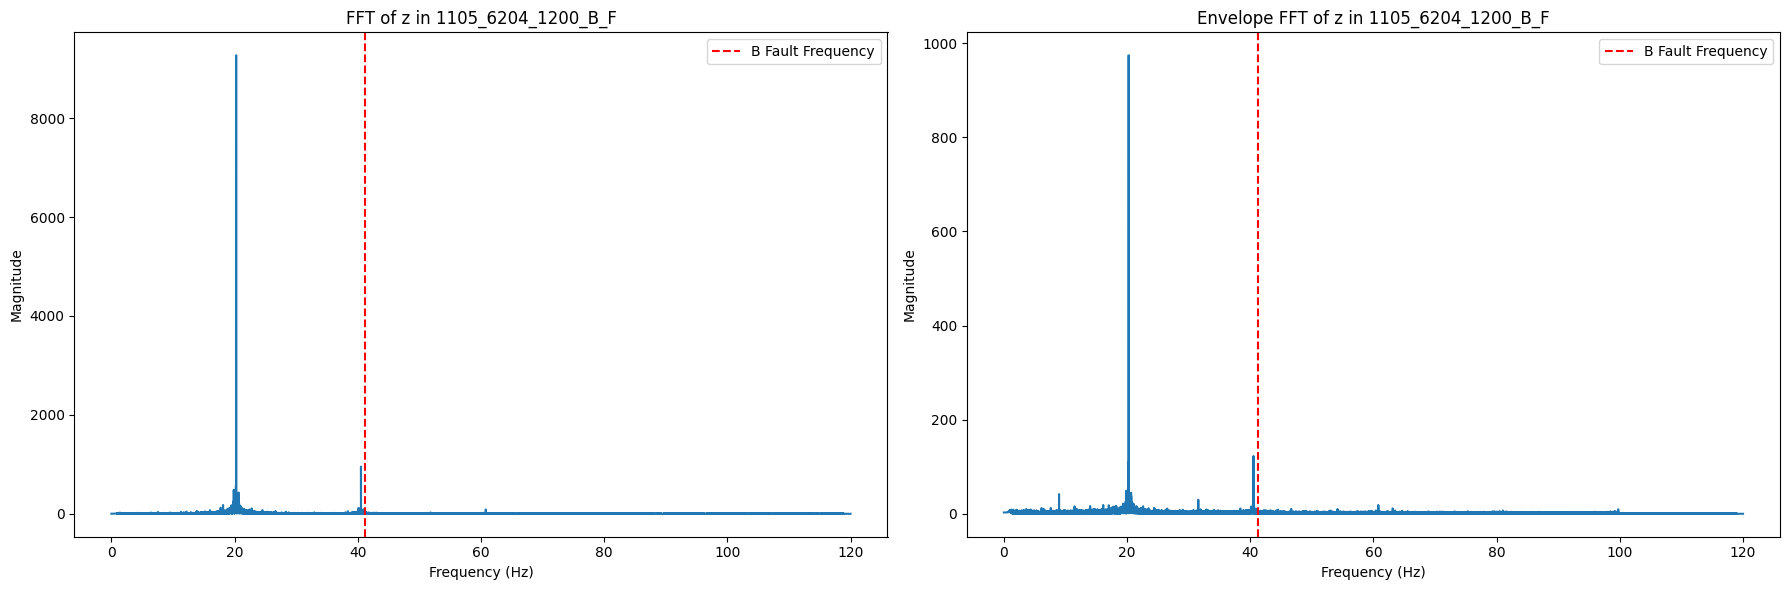

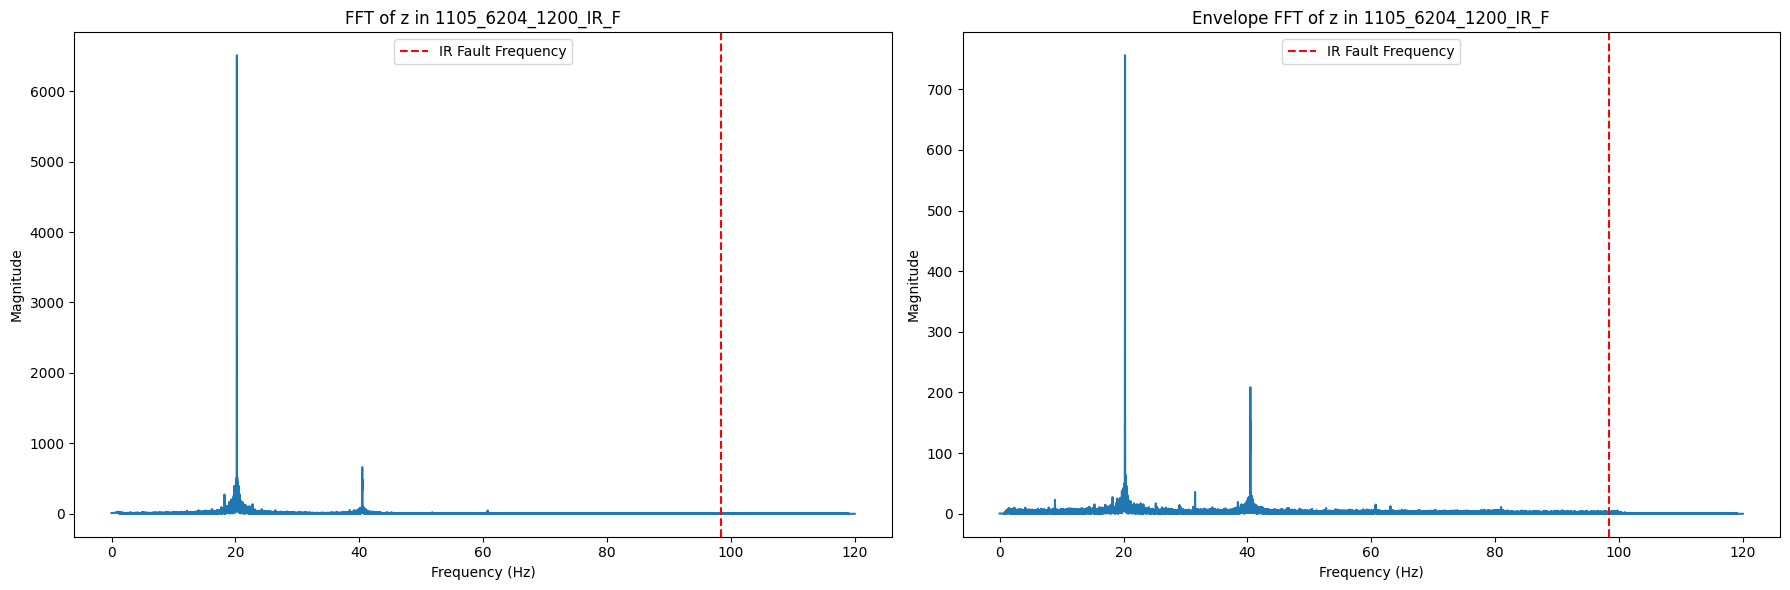

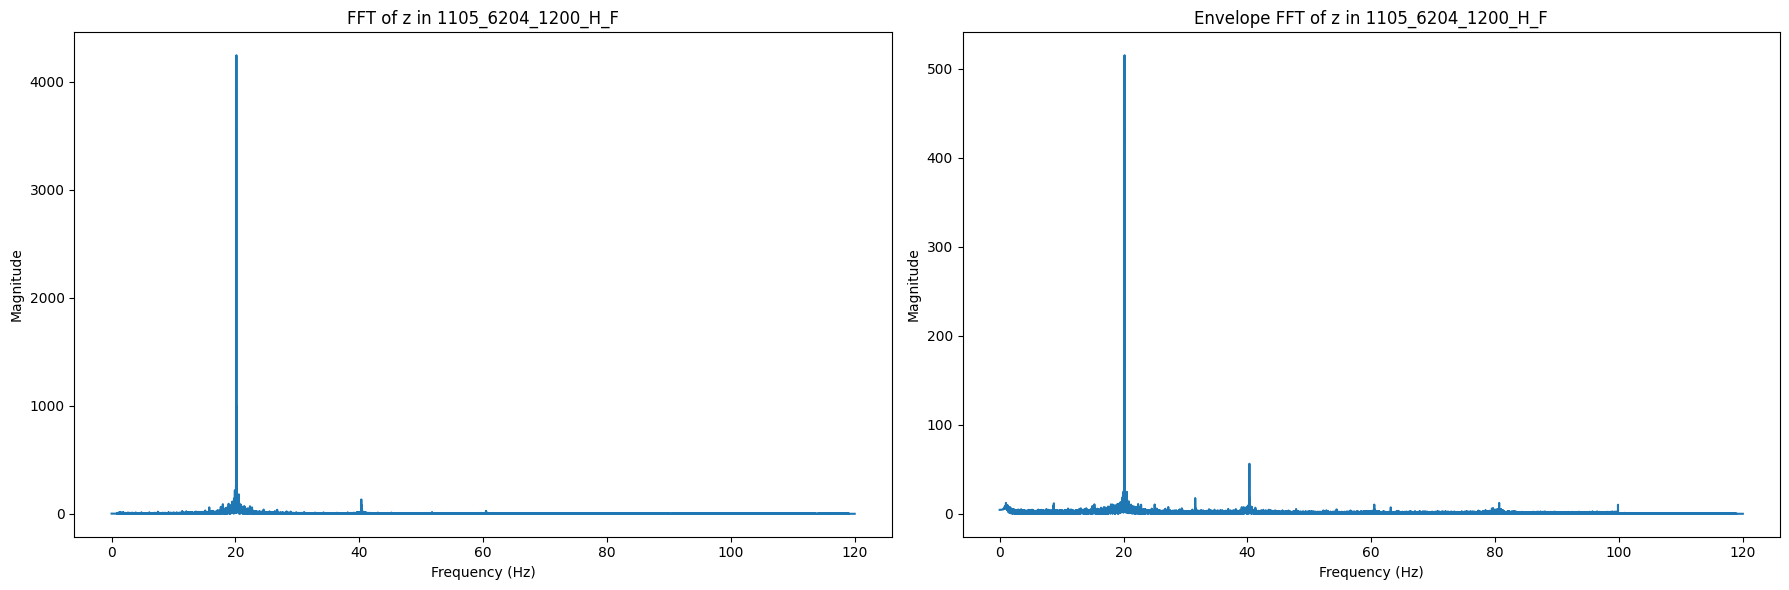

In [11]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert

# Base directory
base_dir = '../output/1105/'

# 뒷부분 자르기
x_len = 240 * 600

# Sampling frequency
fps = 240

# Design bandpass filter
lowcut = 1.0
highcut = 119.0
nyquist = 0.5 * fps
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Conversion factors for different views and axes
conversion_factors = {
    '1001': {'F': 0.074627, 'S': 0.111111},
    '1008': {'F': 0.075757576, 'S': 0.177777778},
    '1011': {'F': 0.075757576},
    '1012': {'F': 0.046296296},
    '1024': {'F': 0.044642857, 'S': 0.075471698},
    '1102': {'F': {'A': 0.0485, 'B': 0.0485}, 'S': {'A': 0.069565217, 'B': 0.066666667}},
    '1103': {'F': {'A': 0.0485, 'B': 0.0485}},
    '1104': {'F': {'A': 0.05, 'B': 0.05}, 'S': {'A': 0.067796610, 'B': 0.065040650}},
    '1105': {'F': {'A': 0.05, 'B': 0.05}}
}

# Fault frequencies for different bearing types and fault types
fault_frequencies = {
    '6204': {'IR': 4.92, 'OR': 3.08, 'B': 2.06},
    '30204': {'IR': 8.8, 'OR': 6.2, 'B': 2.8},
    'default': {'IR': 6.71, 'OR': 4.29, 'B': 2.16}
}

# User-specified targets
target_view = 'F'
target_RPM = None
target_fault_type = None
target_axis = 'z'
target_marker = 'B'

def process_and_plot(file_paths, dir_name):
    data = {}
    parts = dir_name.split('_')
    date = parts[0]
    view = parts[-1]
    fault_type = parts[-2]
    RPM = int(parts[-3])
    bearing_type = parts[-4]

    # Check if the current directory matches the target criteria
    if (target_view and view != target_view
        ) or (target_RPM and RPM != target_RPM
              ) or (target_fault_type and fault_type != target_fault_type):
        return

    # Determine the conversion factor
    if int(date) < 1100:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1)
    else:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(target_marker, 1)

    for axis, file_path in file_paths.items():
        if target_axis and axis != target_axis:
            continue
        if target_marker == 'A':
            values = pd.read_csv(file_path).iloc[:x_len, 0].values
        if target_marker == 'B':
            values = pd.read_csv(file_path).iloc[:x_len, 1].values
        # Apply conversion factor
        values = values * conversion_factor
        data[axis] = values

    if not data:
        return

    # Apply bandpass filter and perform FFT
    fft_results = {}
    envelope_fft_results = {}
    for axis, values in data.items():
        envelope = np.abs(hilbert(values))
        filtered_values = filtfilt(b, a, values)
        filtered_envelope_values = filtfilt(b, a, envelope)
        #envelope = np.abs(hilbert(filtered_values))
        fft_results[axis] = np.fft.fft(filtered_values)
        envelope_fft_results[axis] = np.fft.fft(filtered_envelope_values)
    
    # Compute frequencies
    freqs = np.fft.fftfreq(len(next(iter(data.values()))), 1/fps)
    freqs = np.fft.fftshift(freqs)

    # Determine the fault frequency based on fault_type
    base_frequency = RPM / 60
    fault_frequency = base_frequency * fault_frequencies.get(bearing_type, fault_frequencies['default']).get(fault_type, 100)
    
    # Plot the results
    
    for i, (axis, fft_result) in enumerate(fft_results.items(), 1):
        plt.figure(figsize=(18, 6))
        fft_result = np.fft.fftshift(fft_result)
        envelope_fft_result = np.fft.fftshift(envelope_fft_results[axis])
        positive_freqs = (freqs > 0) & (freqs <= 120)
        
        # Plot FFT result
        plt.subplot(1, 2, 1)
        plt.plot(freqs[positive_freqs], np.abs(fft_result[positive_freqs]))
        plt.title(f'FFT of {axis} in {dir_name}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        if fault_frequency > 0 and fault_frequency <= 120:
            plt.axvline(x=fault_frequency, color='r', linestyle='--', label=f'{fault_type} Fault Frequency')
            plt.legend()
        
        # Plot Envelope FFT result
        plt.subplot(1, 2, 2)
        plt.plot(freqs[positive_freqs], np.abs(envelope_fft_result[positive_freqs]))
        plt.title(f'Envelope FFT of {axis} in {dir_name}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        if fault_frequency > 0 and fault_frequency <= 120:
            plt.axvline(x=fault_frequency, color='r', linestyle='--', label=f'{fault_type} Fault Frequency')
            plt.legend()
    
    plt.tight_layout()
    plt.show()

# Walk through directories and process files
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv', 'r.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        process_and_plot(file_paths, dir_name)

+-----+---------------------+--------+----------------------+-------------------------------+
|     | Directory           | Axis   |   FFT Peak Magnitude |   Envelope FFT Peak Magnitude |
+=====+=====================+========+======================+===============================+
|   0 | 1105_6204_1200_OR_F | z      |              117.131 |                       7.8729  |
+-----+---------------------+--------+----------------------+-------------------------------+
|   1 | 1105_6204_1200_OR_F | z      |              116.469 |                       7.67261 |
+-----+---------------------+--------+----------------------+-------------------------------+
|   2 | 1105_6204_1200_OR_F | z      |              127.261 |                       7.13313 |
+-----+---------------------+--------+----------------------+-------------------------------+
|   3 | 1105_6204_1200_OR_F | z      |              132.158 |                       9.61658 |
+-----+---------------------+--------+----------------------

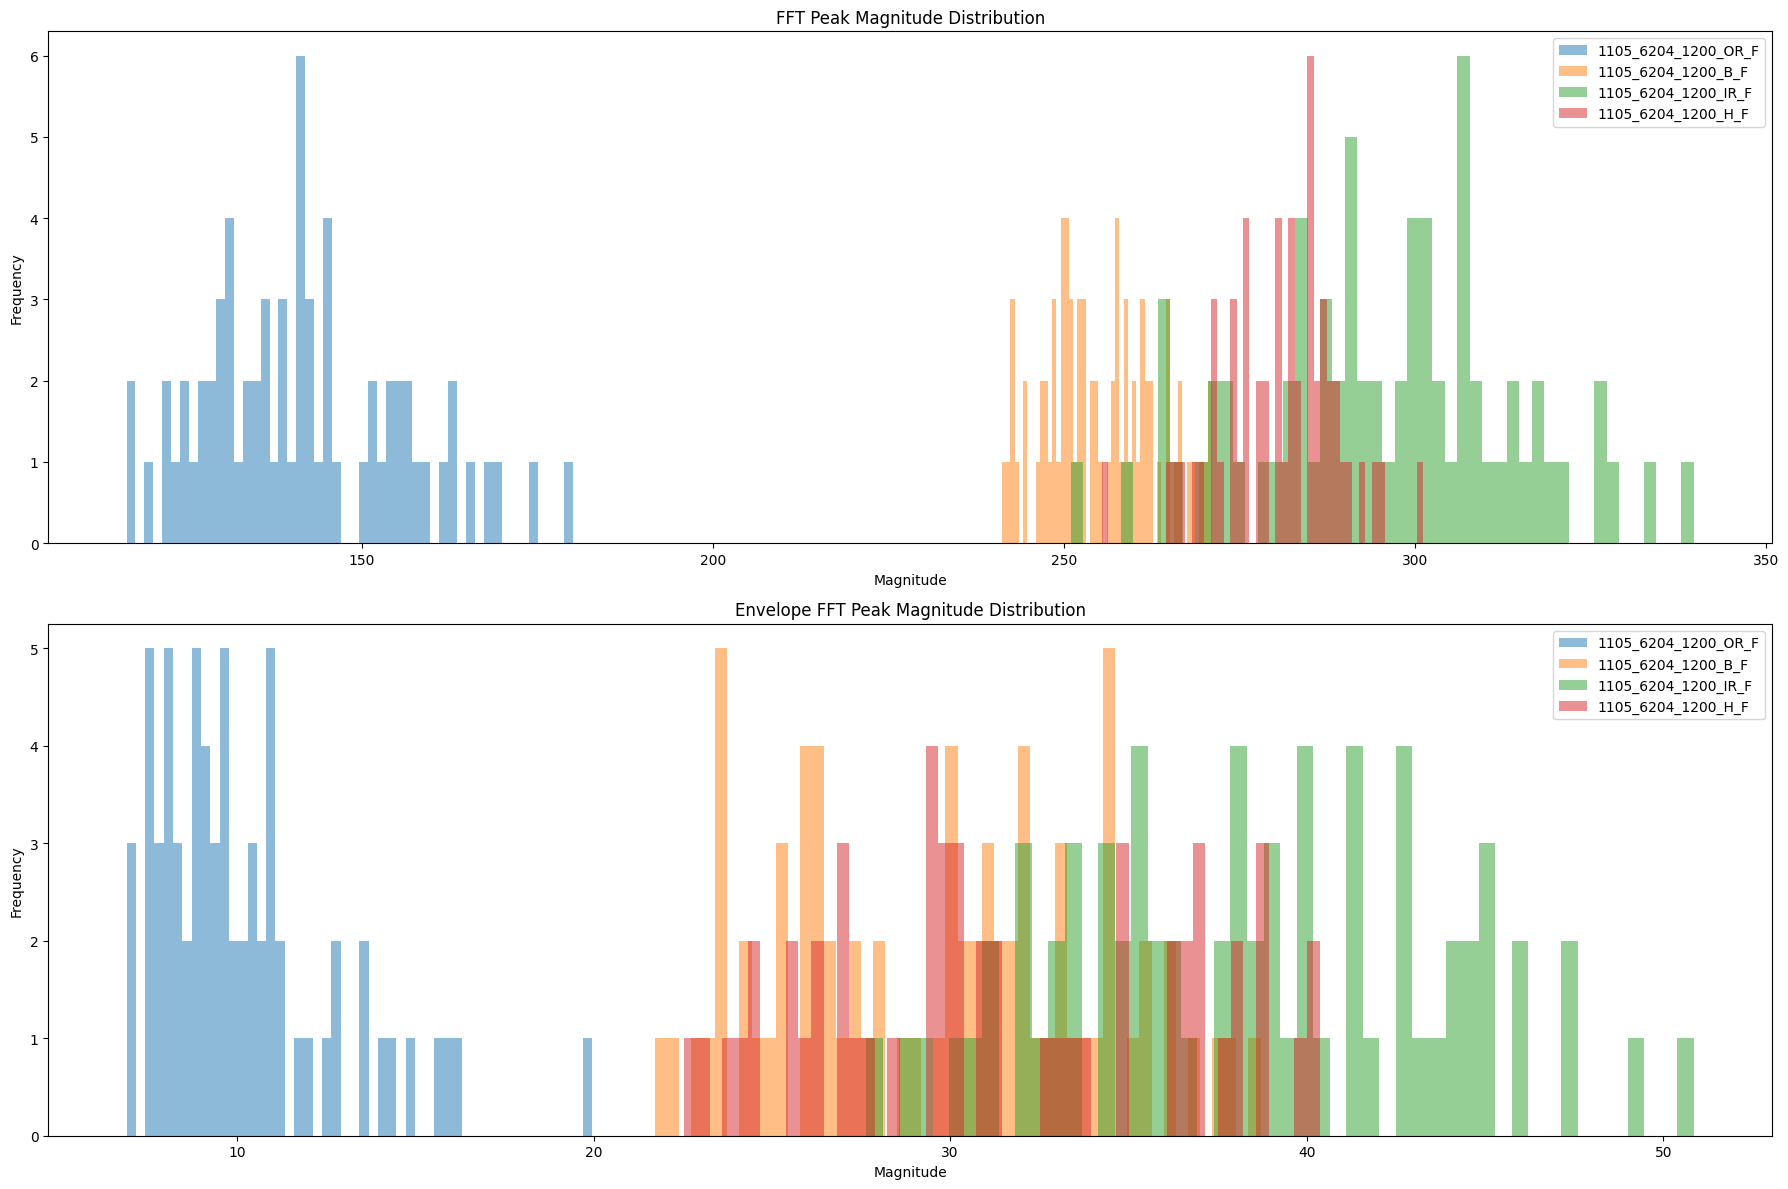

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
from tabulate import tabulate

# Base directory
base_dir = '../output/1105/'

# 뒷부분 자르기
x_len = 240 * 600

# Sampling frequency
fps = 240

# Design bandpass filter
lowcut = 1.0
highcut = 119.0
nyquist = 0.5 * fps
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Conversion factors for different views and axes
conversion_factors = {
    '1001': {'F': 0.074627, 'S': 0.111111},
    '1008': {'F': 0.075757576, 'S': 0.177777778},
    '1011': {'F': 0.075757576},
    '1012': {'F': 0.046296296},
    '1024': {'F': 0.044642857, 'S': 0.075471698},
    '1102': {'F': {'A': 0.0485, 'B': 0.0485}, 'S': {'A': 0.069565217, 'B': 0.066666667}},
    '1103': {'F': {'A': 0.0485, 'B': 0.0485}},
    '1104': {'F': {'A': 0.05, 'B': 0.05}, 'S': {'A': 0.067796610, 'B': 0.065040650}},
    '1105': {'F': {'A': 0.05, 'B': 0.05}}
}

# Fault frequencies for different bearing types and fault types
fault_frequencies = {
    '6204': {'IR': 4.92, 'OR': 3.08, 'B': 2.06},
    '30204': {'IR': 8.8, 'OR': 6.2, 'B': 2.8},
    'default': {'IR': 6.71, 'OR': 4.29, 'B': 2.16}
}

# User-specified targets
target_view = 'F'
target_RPM = 1200
target_fault_type = None
target_axis = 'z'
target_marker = 'A'

def process_and_plot(file_paths, dir_name):
    data = []
    parts = dir_name.split('_')
    date = parts[0]
    view = parts[-1]
    fault_type = parts[-2]
    RPM = int(parts[-3])
    bearing_type = parts[-4]

    # Check if the current directory matches the target criteria
    if (target_view and view != target_view
        ) or (target_RPM and RPM != target_RPM
              ) or (target_fault_type and fault_type != target_fault_type):
        return []

    # Determine the conversion factor
    if int(date) < 1100:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1)
    else:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(target_marker, 1)

    for axis, file_path in file_paths.items():
        if target_axis and axis != target_axis:
            continue
        if target_marker == 'A':
            values = pd.read_csv(file_path).iloc[:x_len, 0].values
        elif target_marker == 'B':
            values = pd.read_csv(file_path).iloc[:x_len, 1].values
        # Apply conversion factor
        values = values * conversion_factor
        values -= np.mean(values)  # 평균을 0으로 만듭니다.

        # Sliding window
        window_size = 2048
        overlap = 1024
        for start in range(0, len(values) - window_size + 1, window_size - overlap):
            window = values[start:start + window_size]
            filtered_values = filtfilt(b, a, window)
            envelope = np.abs(hilbert(filtered_values))
            filtered_envelope_values = filtfilt(b, a, envelope)
            
            # FFT and envelope FFT
            fft_result = np.fft.fft(filtered_values)
            envelope_fft_result = np.fft.fft(filtered_envelope_values)
            
            # Compute frequencies
            freqs = np.fft.fftfreq(len(window), 1/fps)
            positive_freqs = freqs[freqs > 0]
            
            # Find peak magnitudes
            fft_peak_magnitude = np.max(np.abs(fft_result[freqs > 0]))
            envelope_fft_peak_magnitude = np.max(np.abs(envelope_fft_result[freqs > 0]))

            data.append([dir_name, axis, fft_peak_magnitude, envelope_fft_peak_magnitude])
    
    return data

# Walk through directories and process files
all_data = []
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv', 'r.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        data = process_and_plot(file_paths, dir_name)
        all_data.extend(data)

# Create DataFrame for the results
columns = ['Directory', 'Axis', 'FFT Peak Magnitude', 'Envelope FFT Peak Magnitude']
df_data = pd.DataFrame(all_data, columns=columns)

# Display the results
print(tabulate(df_data, headers='keys', tablefmt='grid'))

# Visualize the results
plt.figure(figsize=(18, 12))

# Plot FFT Peak Magnitude
plt.subplot(2, 1, 1)
for directory in df_data['Directory'].unique():
    subset = df_data[df_data['Directory'] == directory]
    plt.hist(subset['FFT Peak Magnitude'], bins=50, alpha=0.5, label=directory)
plt.title('FFT Peak Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()

# Plot Envelope FFT Peak Magnitude
plt.subplot(2, 1, 2)
for directory in df_data['Directory'].unique():
    subset = df_data[df_data['Directory'] == directory]
    plt.hist(subset['Envelope FFT Peak Magnitude'], bins=50, alpha=0.5, label=directory)
plt.title('Envelope FFT Peak Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from tabulate import tabulate

# Base directory
base_dir = '../output/1104/'

# 뒷부분 자르기
x_len = 240 * 600

# Conversion factors for different views and axes
conversion_factors = {
    '1001': {'F': 0.074627, 'S': 0.111111},
    '1008': {'F': 0.075757576, 'S': 0.177777778},
    '1011': {'F': 0.075757576},
    '1012': {'F': 0.046296296},
    '1024': {'F': 0.044642857, 'S': 0.075471698},
    '1102': {'F': {'A': 0.0485, 'B': 0.0485}, 'S': {'A': 0.069565217, 'B': 0.066666667}},
    '1103': {'F': {'A': 0.0485, 'B': 0.0485}},
    '1104': {'F': {'A': 0.05, 'B': 0.05}, 'S': {'A': 0.067796610, 'B': 0.065040650}},
    '1105': {'F': {'A': 0.05, 'B': 0.05}}
}

# User-specified targets
target_view = 'S'
target_RPM = 1400
target_fault_type = None
target_axis = 'z'
target_marker = 'A'  # 'A' 또는 'B'

def calculate_statistics(values):
    peak = np.max(np.abs(values))
    average = np.mean(values)
    rms = np.sqrt(np.mean(values**2))
    crest_factor = peak / rms
    return peak, average, rms, crest_factor

def process_and_calculate(file_paths, dir_name):
    stats = []
    parts = dir_name.split('_')
    date = parts[0]
    view = parts[-1]
    fault_type = parts[-2]
    RPM = int(parts[-3])
    axis = parts[-1]

    # Check if the current directory matches the target criteria
    if (target_view and view != target_view
        ) or (target_RPM and RPM != target_RPM
              ) or (target_fault_type and fault_type != target_fault_type):
        return []

    # Determine the conversion factor
    if int(date) < 1100:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1)
    else:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(target_marker, 1)
    for axis, file_path in file_paths.items():
        if target_axis and axis != target_axis:
            continue
        if target_marker == 'A':
            values = pd.read_csv(file_path).iloc[:x_len, 0].values
        elif target_marker == 'B':
            values = pd.read_csv(file_path).iloc[:x_len, 1].values
        # Apply conversion factor
        values = values * conversion_factor
        values -= np.mean(values)  # 평균을 0으로 만듭니다.
        peak, average, rms, crest_factor = calculate_statistics(values)
        stats.append([dir_name, axis, peak, average, rms, crest_factor])
    
    return stats

# Walk through directories and process files
all_stats = []
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv', 'r.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        stats = process_and_calculate(file_paths, dir_name)
        all_stats.extend(stats)

# Create DataFrame for the results
columns = ['Directory', 'Axis', 'Peak', 'Average', 'RMS', 'Crest Factor']
df_stats = pd.DataFrame(all_stats, columns=columns)

# Display the results
print(tabulate(df_stats, headers='keys', tablefmt='grid'))

+----+--------------------+--------+-----------+--------------+------------+----------------+
|    | Directory          | Axis   |      Peak |      Average |        RMS |   Crest Factor |
+====+====================+========+===========+==============+============+================+
|  0 | 1104_N204_1400_M_S | z      | 0.0360603 | -1.0045e-18  | 0.00933426 |        3.86322 |
+----+--------------------+--------+-----------+--------------+------------+----------------+
|  1 | 1104_N204_1400_H_S | z      | 0.0326015 | -2.42289e-19 | 0.0133766  |        2.4372  |
+----+--------------------+--------+-----------+--------------+------------+----------------+


+-----+---------------------+--------+----------+--------------+-----------+----------------+
|     | Directory           | Axis   |     Peak |      Average |       RMS |   Crest Factor |
+=====+=====================+========+==========+==============+===========+================+
|   0 | 1105_6204_1200_OR_F | z      | 0.147381 |  0.00904644  | 0.0861639 |        1.71047 |
+-----+---------------------+--------+----------+--------------+-----------+----------------+
|   1 | 1105_6204_1200_OR_F | z      | 0.154574 |  0.00931145  | 0.0860894 |        1.79551 |
+-----+---------------------+--------+----------+--------------+-----------+----------------+
|   2 | 1105_6204_1200_OR_F | z      | 0.154574 |  0.00746534  | 0.0911682 |        1.69549 |
+-----+---------------------+--------+----------+--------------+-----------+----------------+
|   3 | 1105_6204_1200_OR_F | z      | 0.157603 |  0.0056986   | 0.095091  |        1.65739 |
+-----+---------------------+--------+----------+-----------

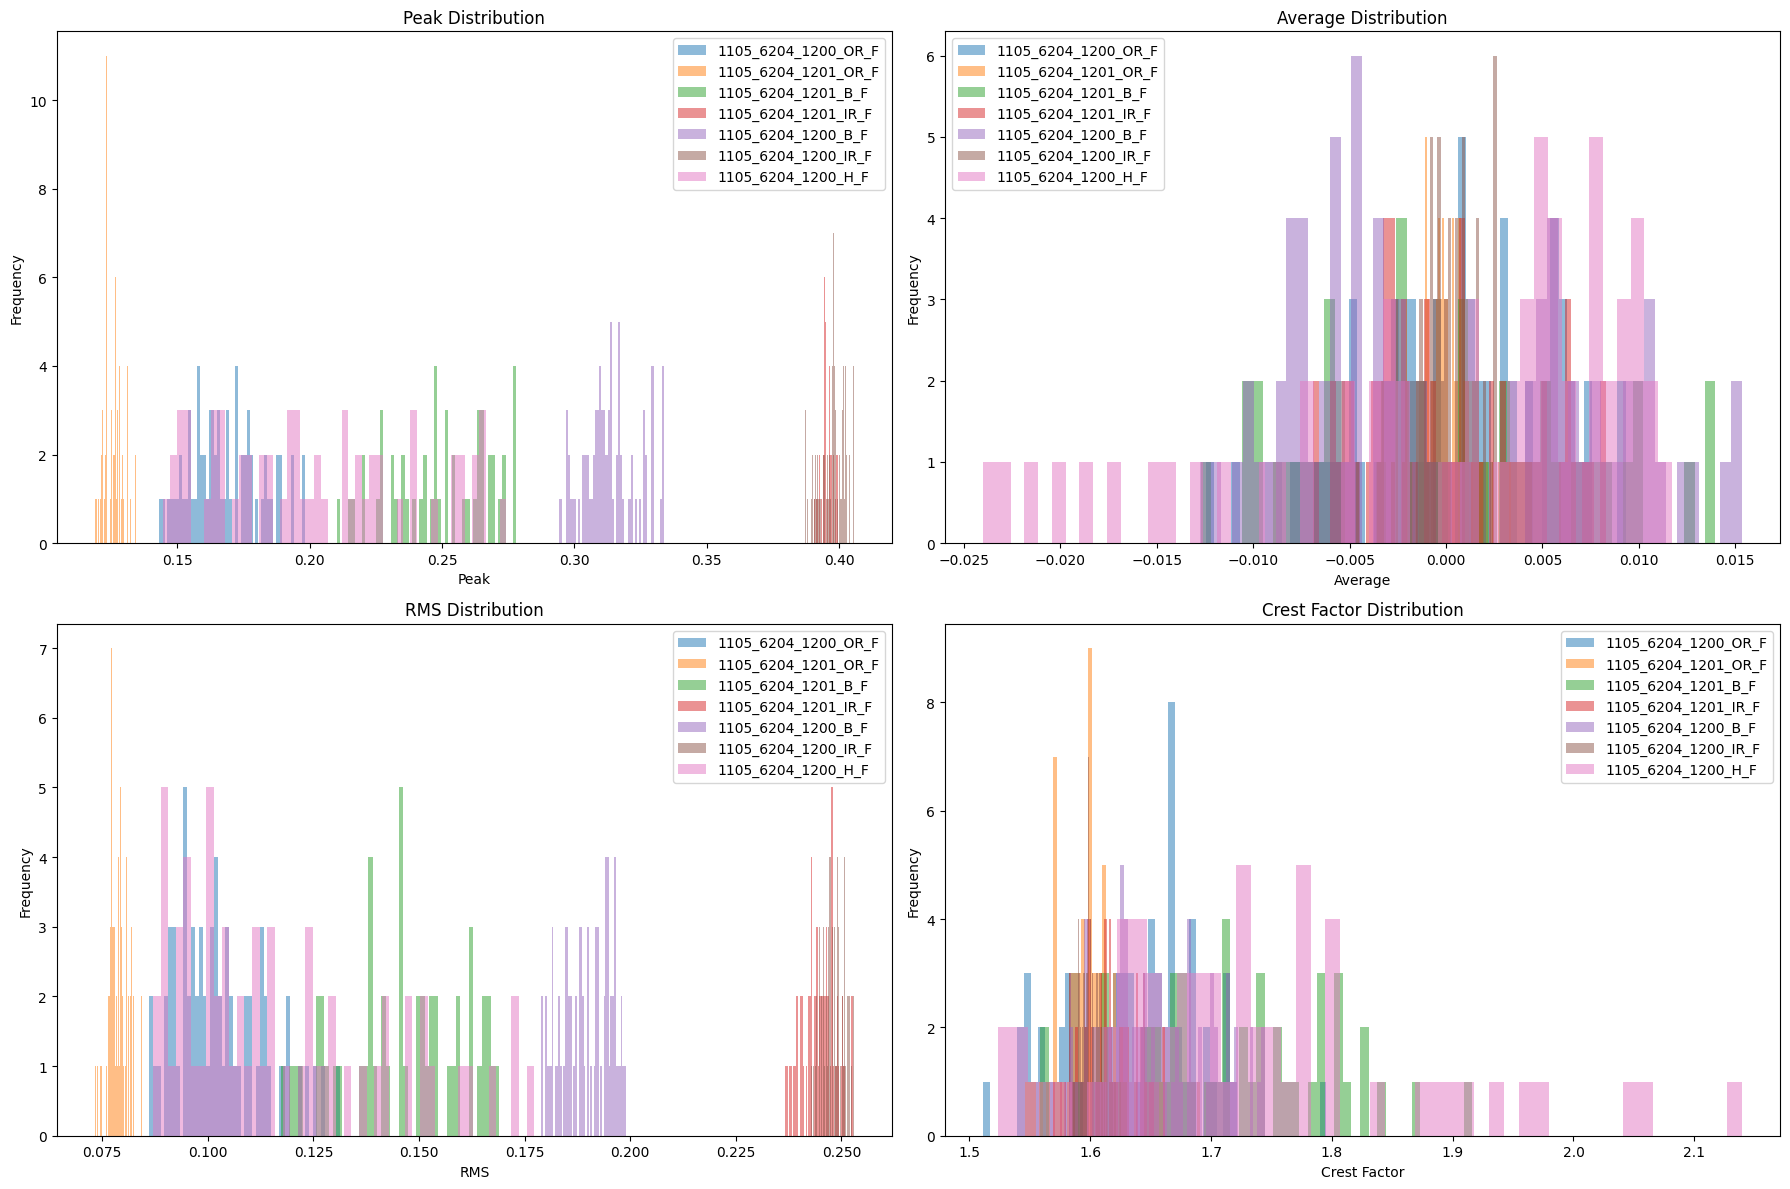

In [10]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Base directory
base_dir = '../output/1105/'

# 뒷부분 자르기
x_len = 240 * 600

# Conversion factors for different views and axes
conversion_factors = {
    '1001': {'F': 0.074627, 'S': 0.111111},
    '1008': {'F': 0.075757576, 'S': 0.177777778},
    '1011': {'F': 0.075757576},
    '1012': {'F': 0.046296296},
    '1024': {'F': 0.044642857, 'S': 0.075471698},
    '1102': {'F': {'A': 0.0485, 'B': 0.0485}, 'S': {'A': 0.069565217, 'B': 0.066666667}},
    '1103': {'F': {'A': 0.0485, 'B': 0.0485}},
    '1104': {'F': {'A': 0.05, 'B': 0.05}, 'S': {'A': 0.067796610, 'B': 0.065040650}},
    '1105': {'F': {'A': 0.05, 'B': 0.05}}
}

# User-specified targets
target_view = 'F'
target_RPM = None
target_fault_type = None
target_axis = 'z'
target_marker = 'A'  # 'A' 또는 'B'

def calculate_statistics(values):
    peak = np.max(np.abs(values))
    average = np.mean(values)
    rms = np.sqrt(np.mean(values**2))
    crest_factor = peak / rms
    return peak, average, rms, crest_factor

def process_and_calculate(file_paths, dir_name):
    stats = []
    parts = dir_name.split('_')
    date = parts[0]
    view = parts[-1]
    fault_type = parts[-2]
    RPM = int(parts[-3])
    axis = parts[-1]

    # Check if the current directory matches the target criteria
    if (target_view and view != target_view
        ) or (target_RPM and RPM != target_RPM
              ) or (target_fault_type and fault_type != target_fault_type):
        return []

    # Determine the conversion factor
    if int(date) < 1100:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1)
    else:
        conversion_factor = conversion_factors.get(date, {}).get(view, 1).get(target_marker, 1)
    for axis, file_path in file_paths.items():
        if target_axis and axis != target_axis:
            continue
        if target_marker == 'A':
            values = pd.read_csv(file_path).iloc[:x_len, 0].values
        elif target_marker == 'B':
            values = pd.read_csv(file_path).iloc[:x_len, 1].values
        # Apply conversion factor
        values = values * conversion_factor
        values -= np.mean(values)  # 평균을 0으로 만듭니다.

        # Sliding window
    window_size = 2048
    overlap = 1024
    for start in range(0, len(values) - window_size + 1, window_size - overlap):
        window = values[start:start + window_size]
        peak, average, rms, crest_factor = calculate_statistics(window)
        stats.append([dir_name, axis, peak, average, rms, crest_factor])
    
    return stats

# Walk through directories and process files
all_stats = []
for root, dirs, files in os.walk(base_dir):
    file_paths = {}
    for file in files:
        if file in ['x.csv', 'y.csv', 'z.csv', 'r.csv']:
            file_paths[file[0]] = os.path.join(root, file)
    
    if len(file_paths) >= 2:  # Ensure at least two files are present
        dir_name = os.path.basename(root)
        stats = process_and_calculate(file_paths, dir_name)
        all_stats.extend(stats)

# Create DataFrame for the results
columns = ['Directory', 'Axis', 'Peak', 'Average', 'RMS', 'Crest Factor']
df_stats = pd.DataFrame(all_stats, columns=columns)

# Display the results
print(tabulate(df_stats, headers='keys', tablefmt='grid'))

# Visualize the results
plt.figure(figsize=(18, 12))

# Plot Peak
plt.subplot(2, 2, 1)
for directory in df_stats['Directory'].unique():
    subset = df_stats[df_stats['Directory'] == directory]
    plt.hist(subset['Peak'], bins=50, alpha=0.5, label=directory)
plt.title('Peak Distribution')
plt.xlabel('Peak')
plt.ylabel('Frequency')
plt.legend()

# Plot Average
plt.subplot(2, 2, 2)
for directory in df_stats['Directory'].unique():
    subset = df_stats[df_stats['Directory'] == directory]
    plt.hist(subset['Average'], bins=50, alpha=0.5, label=directory)
plt.title('Average Distribution')
plt.xlabel('Average')
plt.ylabel('Frequency')
plt.legend()

# Plot RMS
plt.subplot(2, 2, 3)
for directory in df_stats['Directory'].unique():
    subset = df_stats[df_stats['Directory'] == directory]
    plt.hist(subset['RMS'], bins=50, alpha=0.5, label=directory)
plt.title('RMS Distribution')
plt.xlabel('RMS')
plt.ylabel('Frequency')
plt.legend()

# Plot Crest Factor
plt.subplot(2, 2, 4)
for directory in df_stats['Directory'].unique():
    subset = df_stats[df_stats['Directory'] == directory]
    plt.hist(subset['Crest Factor'], bins=50, alpha=0.5, label=directory)
plt.title('Crest Factor Distribution')
plt.xlabel('Crest Factor')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()